# How to convert 3D slip model in 2D ASAGI file ?
In this notebook, we will describe the different steps used to project the 3D slip model for the Maduo earthquake into a 2D grid in order to 
create an ASAGI file to be used with FL33 in SeisSol. 

Let's first define the different functions that we will use:

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.interpolate import griddata
from netCDF4 import Dataset
import scipy.ndimage as ndima
from scipy import signal
import pyproj
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

def project_3D_pts_on_plane(p_xyz, in_xyz):
    # perpendicular projection of 3D points onto a plane
    # xyzp = x,y,z coordinates of at least 3 pts belonging to the plane
    # in_xyz = x,y,z coordinates of the points to project
    # out_xyz = x,y,z coordinates of the projected points
    AB = p_xyz[1, :] - p_xyz[0, :]
    AC = p_xyz[2, :] - p_xyz[0, :]
    
    n = np.cross(AB, AC)
    d = np.dot(p_xyz[0, :], n.T)

    t0 = - (n[0]*in_xyz[:, 0] + n[1]*in_xyz[:, 1] + n[2]*in_xyz[:, 2] - d)/(n[0]**2 + n[1]**2 + n[2]**2)
    X = in_xyz[:, 0] + n[0] * t0
    Y = in_xyz[:, 1] + n[1] * t0
    Z = in_xyz[:, 2] + n[2] * t0
    
    out_xyz = np.array([X, Y, Z]).T
    
    return out_xyz
        
def plane_coord(x1, x2, y1, y2, dip, strike, depth1, depth2):
    # Given a strike, a dip angle and the coordinates of the two top corners of a plane,compute
    # the two bottom corners coordinates of that plane.
    # depth 1: alitude of the top of the fault (= or > 0)
    # depth 2: depth of the fault bottom (< 0)
    # (x1,y1), (x2,y2) coordinates of the two top corners of the plane
    # out : xp,yp,zp  coordinates of the four corners of the plane
    
    dx = np.sin(np.deg2rad(strike-90)) * ( abs(depth2-depth1) / np.tan(np.deg2rad(dip)))
    dy = np.cos(np.deg2rad(strike-90)) * ( abs(depth2-depth1) / np.tan(np.deg2rad(dip)))

    xp = [x1, x2, x2 - dx, x1 - dx, x1]
    yp = [y1, y2, y2 + dy, y1 + dy, y1]
    zp = [depth1, depth1, depth2, depth2, depth1]
    
    return xp, yp, zp


def compute_unit_vec_trans_plane(xp, yp, zp):
    # xp,yp,zp coordinates of the 4 corners of the plane (but only 3 pts needed)
    # One of the three points will define the origin of the 2D coordinates system. With the origin pt,
    # the two others pts must define the strike and dip direction.
    
    # hw, hh, th, tw: matrices and scalar needed to go from the global coordinates system
    # to the local coordinates system defined by the plane.
    # hh and hw allows defining a 2D coordinate system which is contained in the given plane
    # hh is the unit vector defining the plane strike direction
    # hw is the unit vector defining the plane dip direction
    # th and tw are the scalars that defined the origin of the 2D coordinates system
 
    hw = np.array([xp[1], yp[1], zp[1]] - np.array([xp[2], yp[2], zp[2]])) # fault 3
    hw = hw / np.linalg.norm(hw)
    hh = np.array([xp[3], yp[3], zp[3]]) - np.array([xp[2], yp[2], zp[2]])
    hh = hh / np.linalg.norm(hh)
    th = -np.dot(np.array([xp[2], yp[2], zp[2]]), hh)
    tw = -np.dot(np.array([xp[2], yp[2], zp[2]]), hw)
    
    return hw, hh, th, tw 

def interpolate_2dgrid(xmin,xmax,ymin,ymax,step,data,method='cubic'):    
    # xmin,xmax,ymin,ymax,step : info needed to discretize the plane
    # data (3 x n matrix: x,y coordinates and value of the n data we want to interpolate)   
    l = xmax - xmin
    w = ymax - ymin

    nl = int(l / step)
    nw = int(w / step)

    xr = np.linspace(xmin, xmax, nl)
    yr = np.linspace(ymin, ymax, nw)

    data[:, 0] = data[:, 0]
    data[:, 1] = data[:, 1]

    grid_x, grid_y = np.meshgrid(xr, yr)

    data_interp = griddata(data[:, 0:2], data[:, 2], (grid_x, grid_y), method='cubic')
    data_interp = np.nan_to_num(data_interp)

    return grid_x, grid_y, data_interp

def writeNetcdf4Paraview(sname, x, y, aName, aData):
    "create a netcdf file readable by paraview (but not by ASAGI)"
    fname = sname + "_paraview.nc"
    print("writing " + fname)
    ####Creating the netcdf file
    nx = x.shape[0]
    ny = y.shape[0]
    rootgrp = Dataset(fname, "w", format="NETCDF4")
    rootgrp.createDimension("u", nx)
    rootgrp.createDimension("v", ny)

    vx = rootgrp.createVariable("u", "f4", ("u",))
    vx[:] = x
    vy = rootgrp.createVariable("v", "f4", ("v",))
    vy[:] = y
    for i in range(len(aName)):
        vTd = rootgrp.createVariable(aName[i], "f4", ("v", "u"))
        vTd[:, :] = aData[i][:, :]
    rootgrp.close()


def writeNetcdf4SeisSol(sname, x, y, aName, aData):
    "create a netcdf file readable by ASAGI (but not by paraview)"
    ########## creating the file for SeisSol
    fname = sname + "_ASAGI.nc"
    print("writing " + fname)
    ####Creating the netcdf file
    nx = x.shape[0]
    ny = y.shape[0]

    rootgrp = Dataset(fname, "w", format="NETCDF4")

    rootgrp.createDimension("u", nx)
    rootgrp.createDimension("v", ny)

    vx = rootgrp.createVariable("u", "f4", ("u",))
    vx[:] = x
    vy = rootgrp.createVariable("v", "f4", ("v",))
    vy[:] = y
    ldata4 = [(name, "f4") for name in aName]
    ldata8 = [(name, "f8") for name in aName]
    mattype4 = np.dtype(ldata4)
    mattype8 = np.dtype(ldata8)
    mat_t = rootgrp.createCompoundType(mattype4, "material")

    # this transform the 4 D array into an array of tuples
    arr = np.stack([aData[i] for i in range(len(aName))], axis=2)
    newarr = arr.view(dtype=mattype8)
    newarr = newarr.reshape(newarr.shape[:-1])
    mat = rootgrp.createVariable("data", mat_t, ("v", "u"))
    mat[:] = newarr
    rootgrp.close()

def write_yaml_file(yamlfile, asagifile, segmentID, hh, hw, th, tw):

    nb_seg = len(asagifile)
    template_yaml_begining = f"""!Switch
[strike_slip, dip_slip]: !EvalModel
    parameters: [strike_slip, dip_slip]
    model: !Switch
        [strike_slip, dip_slip]: !Any
          components:"""
    template_yaml_end = f"""
    components: !FunctionMap
       map:
          #Note the minus on strike_slip to acknowledge the different convention of SeisSol (T_s>0 means right-lateral)
          strike_slip: return -strike_slip;
          dip_slip: return dip_slip;
[acc_time, effective_rise_time,rupture_onset,tau_S,tau_R]: !EvalModel
    parameters: [acc_time, effective_rise_time, rupture_onset]
    model: !ConstantMap
         map:
            acc_time: 0.1
            effective_rise_time: 1.0
            rupture_onset: 0.0
    components: !FunctionMap
       map:
         acc_time: return acc_time;
         effective_rise_time: return effective_rise_time;
         rupture_onset: return rupture_onset;
         tau_S: return acc_time/1.27;
         tau_R: return effective_rise_time - 2.*acc_time/1.27;
        """
    fname = f"{yamlfile}.yaml"
    with open(fname, "w") as fid:
        fid.write(template_yaml_begining)
        for i in range(0, nb_seg):
            template_yaml_segment = f"""
            - !GroupFilter
               groups: {segmentID[i]}
               components: !AffineMap
                    matrix:
                      ua: [{hh[i][0]}, {hh[i][1]}, {hh[i][2]}]
                      ub: [{hw[i][0]}, {hw[i][1]}, {hw[i][2]}]
                    translation:
                      ua: {th[i]}
                      ub: {tw[i]}
                    components: !Any
                      - !ASAGI
                          file: {asagifile[i]}_ASAGI.nc
                          parameters: [strike_slip, dip_slip]
                          var: data
                          interpolation: linear
                      - !ConstantMap
                        map:
                          strike_slip: 0.0
                          dip_slip:    0.0"""
            fid.write(template_yaml_segment)
        fid.write(template_yaml_end)
    print(f"done writing {fname}")

    

## Load the slip model 
The slip model for the Maduo earthquake is composed of three segments. We will detail the procedure for the first segment. The procedure applied for the two other segments is exactly the same.

Let's first load the slip model and convert its coordinates into the same projection used for the mesh.

Each segment is discretized into triangular subfaults. 
 - "fault_geom_sgmt_1_coord.txt" contains the coordinates of each vertex of the fault
 -  In "fault_geom_sgmt_1_tri.txt", each line represents the indices of the three vertex that form a triangle.
 - "fault_slip_sgmt_1.in" contain the x,y,z coordinates of the subfaults barycenter as well as the strike-slip and dip slip.

In [22]:
# Define the projections used for the slip model and for the mesh in order to convert the coordinates of the 
# slip model into the one used for the mesh.

projini = pyproj.Proj('EPSG:32647')  # Projection of the slip model
projfinal = pyproj.Proj(proj='lcc', init='EPSG:3415')  # projection of the mesh

# if the mesh has been shifted to 0, define the coordinates of the origin of the mesh.
x0 = 0 #-960000 
y0 = 0 #2110000

##################
### Segment 1 ###
#################
# Load the slip model
tri1 = np.loadtxt('/home/marcmath/Bureau/Work/tibet/Duo/last/fault_geom_sgmt_1_tri.txt')
xyz1 = np.loadtxt('/home/marcmath/Bureau/Work/tibet/Duo/last/fault_geom_sgmt_1_coord.txt')
slipmat1 = np.loadtxt('/home/marcmath/Bureau/Work/tibet/Duo/last/fault_slip_sgmt_1.in')

# Convert slip model geometry in the same coordinates system as Maduo meshing
XY_0,XY_1 = pyproj.transform(projini,projfinal,xyz1[:,0],xyz1[:,1])
xyz1[:,0] = XY_0 - x0
xyz1[:,1] = XY_1 - y0

XY_0,XY_1 = pyproj.transform(projini,projfinal,slipmat1[:,0],slipmat1[:,1])
slipmat1[:,0] = XY_0 - x0
slipmat1[:,1] = XY_1 - y0

bary1 = slipmat1[:,0:3]  # subfault barycenter
ss1   = slipmat1[:,3]  # strike-slip (m)
ds1   = slipmat1[:,4]  # dip-slip (m)
xy1    = xyz1[xyz1[:,2]==0]  # x,y coordinates of the surface fault trace
minx  = np.min(xy1[:,0])  # min x coordinates of the surface fault trace
maxx  = np.max(xy1[:,0])  # max x coordinates of the surface fault trace

## Define a plane that best approximates the 3D fault segment

We want to convert a 3D slip model into a 2D one. To that end, given the mean strike and dip of the 3D fault segment, 
we first define a plane that best approximates the 3D fault segment.

In [23]:
# Compute the mean strike of the fault
p       = np.polyfit(xy1[:,0],xy1[:,1],1); 
ys1     = p[0] * np.array([minx, maxx]) + p[1];
alpha   = np.degrees(np.arctan((maxx-minx)/ (ys1[0]-ys1[-1])));
strike1 = 180 + alpha;

# Compute the corner coordinates of a plane that approximates the 3D fault
maxz1     = 0 # altitude max of the surface fault trace (m)
depthmax1 = min(xyz1[:,2]) # m
dip1      = 81.6  # Dip of the segment
xp1, yp1, zp1 = plane_coord(minx, maxx, ys1[0], ys1[-1], -dip1, strike1, maxz1, depthmax1)
p_xyz1 = np.array([xp1, yp1, zp1]).T # Coordinates of the plane corners

## Project the subfaults barycenter onto the plane

Then, we project the 3D barycenter of each subfault perpendicularly onto the plane. 
Each point of our slip model now lie onto a plane.

In [24]:
# project the barycenter of each subfault on the plane
bary_proj1 = project_3D_pts_on_plane(p_xyz1,bary1)

## Convert the 3D coordinates system in 2D
Now, we need to convert the projected 3D points into a 2D coordinates system define by the plane. 

We first define the 2D coordinate system defined by the plane using the function "compute_unit_vec_trans_plane". Then we translate the 3D coordinates of all the points (plane's four corners and projected slip model) in 2D.

In [25]:
# compute scalar and vector needed to pass form 3D from 2D
ub1, ua1, ta1, tb1 = compute_unit_vec_trans_plane(xp1,yp1,zp1)

# Convert 3D coordinates in 2D coordinates
# Plane
xa  = np.dot(np.array([xp1, yp1, zp1]).T, ua1) + ta1
xb  = np.dot(np.array([xp1, yp1, zp1]).T, ub1) + tb1
xyp1 = np.transpose(np.vstack((xa, xb))) # coordinates of the plane corners in 2D

# subfault barycenter
xa  = np.dot(bary_proj1, ua1) + ta1
xb  = np.dot(bary_proj1, ub1) + tb1
xyb1 = np.transpose(np.vstack((xa, xb))) # coordinates of the subfaults barycenter in 2D

## Interpolate the slip model on the 2D grid
Cool, the most diffuclt part is done. We can discretize the 2D plane into a reular grid and interpolate the slip model at each point of the grid

We also smooth the interpolated slip model and apply a tappering function at both edges and at the bottom of the fault. This is to avoid having strong stress changes at the edges of the fault afterward (in SeisSol).

In [26]:
# Discretize the plane and interpolate the slip model
step1 = 800
grid_x1, grid_y1, ssi1 = interpolate_2dgrid(np.min(xyp1[:,0]),np.max(xyp1[:,0]),np.min(xyp1[:,1]),np.max(xyp1[:,1]),step1,np.c_[xyb1,ss1],'nearest')
grid_x1, grid_y1, dsi1 = interpolate_2dgrid(np.min(xyp1[:,0]),np.max(xyp1[:,0]),np.min(xyp1[:,1]),np.max(xyp1[:,1]),step1,np.c_[xyb1,ds1],'nearest')

ssi1[-1,:] = ssi1[-2,:]; # to avoid a line with 0 slip at the surface
dsi1[-1,:] = dsi1[-2,:]; # to avoid a line with 0 slip at the surface

# Smooth the slip model 
dsi1 = ndima.median_filter(dsi1,size=7)
ssi1 = ndima.median_filter(ssi1,size=7)

# Apply a tappering function to have a smooth decrease of slip at the edges of the fault
# Apply the tappering function along the lines
wind    = signal.windows.tukey(np.shape(dsi1)[1],alpha=0.25)
dsi1tuk = np.zeros(np.shape(dsi1))
ssi1tuk = np.zeros(np.shape(dsi1))
for i in range(0, np.shape(dsi1)[0]):
    dsi1tuk[i,:] = dsi1[i,:] * wind
    ssi1tuk[i,:] = ssi1[i,:] * wind
    
# Apply the tappering function along the rows
wind = signal.windows.tukey(np.shape(dsi1)[0],alpha=0.25)
wind[int(np.shape(dsi1)[0]/2)::] = 1 # do not tapper the slip at the surface
dsi1tuk2 = np.zeros(np.shape(dsi1))
ssi1tuk2 = np.zeros(np.shape(dsi1))

for i in range(0, np.shape(dsi1)[1]):
    dsi1tuk2[:,i] =  dsi1tuk[:,i] * wind   
    ssi1tuk2[:,i] =  ssi1tuk[:,i] * wind 

## Create the ASAGI file
It is almost done, we just have to create the Netcdf file readable by ASAGI! We also create a Netcdf file that can be read by Paraview. That allows us to check that everything looks correct.

In [27]:
# Create the asagi file 
file_prefix = "fault1_ss_ds"
ldataName = ["strike_slip", "dip_slip"]
lgridded_myData = [ssi1tuk2, dsi1tuk2]
writeNetcdf4SeisSol(file_prefix, grid_x1[0,:], grid_y1[:,1], ldataName, lgridded_myData)
writeNetcdf4Paraview(file_prefix, grid_x1[0,:], grid_y1[:,1], ldataName, lgridded_myData)


writing fault1_ss_ds_ASAGI.nc
writing fault1_ss_ds_paraview.nc


## Repeat for segment 2 and 3
We will apply the same procedure on the second and third segments. Then we will create automatically the .yaml file needed to run FL33 in SeisSol

### Segment 2:

In [28]:
##################
### Segment 2 ###
#################
# Load the slip model

tri2 = np.loadtxt('/home/marcmath/Bureau/Work/tibet/Duo/last/fault_geom_sgmt_2_tri.txt')
xyz2 = np.loadtxt('/home/marcmath/Bureau/Work/tibet/Duo/last/fault_geom_sgmt_2_coord.txt')
slipmat2 = np.loadtxt('/home/marcmath/Bureau/Work/tibet/Duo/last/fault_slip_sgmt_2.in')

# Convert slip model geometry in the same coordinates system as Maduo meshing

XY_0,XY_1 = pyproj.transform(projini,projfinal,xyz2[:,0],xyz2[:,1])
xyz2[:,0] = XY_0 - x0
xyz2[:,1] = XY_1 - y0
XY_0,XY_1 = pyproj.transform(projini,projfinal,slipmat2[:,0],slipmat2[:,1])
slipmat2[:,0] = XY_0 - x0
slipmat2[:,1] = XY_1 - y0

bary2 = slipmat2[:,0:3]; # subfault barycenter
ss2 = slipmat2[:,3];  # strike-slip (m)
ds2 = slipmat2[:,4]; # dip-slip (m)
xy2=xyz2[xyz2[:,2]==0]; #x,y coordinates of the surface fault trace
minx2  = np.min(xy2[:,0])
maxx2  = np.max(xy2[:,0])

# Compute the mean strike of the fault
p      = np.polyfit(xy2[:,0],xy2[:,1],1); # fault 1
ys2     = p[0] * np.array([minx2, maxx2]) + p[1];
alpha  = np.degrees(np.arctan((maxx2-minx2)/ (ys2[0]-ys2[-1])));
strike2 = 180 + (alpha);


# Compute the coordinates of a plane that approximates the 3D fault
maxz2     = 0 # altitude max of the surface fault trace
depthmax2 = min(xyz2[:,2]) # km
dip2      = 81.6 #
xp2, yp2, zp2 = plane_coord(minx2, maxx2, ys2[0], ys2[-1], -dip2, strike2, maxz2, depthmax2) 
p_xyz2 = np.array([xp2, yp2, zp2]).T #Coordinates of the plane corners

# compute scalar and vector needed to pass form 3D from 2D
ub2, ua2, ta2, tb2 = compute_unit_vec_trans_plane(xp2,yp2,zp2)

# project the barycenter of each subfault on the plane
bary_proj2 = project_3D_pts_on_plane(p_xyz2,bary2)

# Convert 3D coordinates in 2D coordinates
# Plane
xa  = np.dot(np.array([xp2, yp2, zp2]).T, ua2) + ta2
xb  = np.dot(np.array([xp2, yp2, zp2]).T, ub2) + tb2
xyp2 = np.transpose(np.vstack((xa, xb))) # coordinates of the plane corners in 2D

# subfault barycenter
xa  = np.dot(bary_proj2, ua2) + ta2
xb  = np.dot(bary_proj2, ub2) + tb2
xyb2 = np.transpose(np.vstack((xa, xb))) # coordinates of the subfaults barycenter in 2D

# Discretize the plane and interpolate the slip model
step2 = 800
grid_x2, grid_y2, ssi2 = interpolate_2dgrid(np.min(xyp2[:,0]),np.max(xyp2[:,0]),np.min(xyp2[:,1]),np.max(xyp2[:,1]),step2,np.c_[xyb2,ss2],'nearest')
grid_x2, grid_y2, dsi2 = interpolate_2dgrid(np.min(xyp2[:,0]),np.max(xyp2[:,0]),np.min(xyp2[:,1]),np.max(xyp2[:,1]),step2,np.c_[xyb2,ds2],'nearest')

# Smooth the slip model 
dsi2=ndima.median_filter(dsi2,size=7)
ssi2=ndima.median_filter(ssi2,size=7)

# Apply a tappering function to have a smooth decrease of slip at the edges of the fault
# Apply the tappering function along the lines
wind = signal.windows.tukey(np.shape(dsi2)[1],alpha=0.3)
dsi2tuk = np.zeros(np.shape(dsi2))
ssi2tuk = np.zeros(np.shape(dsi2))
for i in range(0, np.shape(dsi2)[0]):
    dsi2tuk[i,:] = dsi2[i,:] * wind
    ssi2tuk[i,:] = ssi2[i,:] * wind
    
# Apply the tappering function along the rows
wind = signal.windows.tukey(np.shape(dsi2)[0],alpha=0.3)
wind[int(np.shape(dsi2)[0]/2)::] = 1
dsi2tuk2 = np.zeros(np.shape(dsi2))
ssi2tuk2 = np.zeros(np.shape(dsi2))

for i in range(0, np.shape(dsi2)[1]):
    dsi2tuk2[:,i] =  dsi2tuk[:,i] * wind   
    ssi2tuk2[:,i] =  ssi2tuk[:,i] * wind  
    
    
# Create the asagi file 
file_prefix = "fault2_ss_ds"
ldataName = ["strike_slip", "dip_slip"]
lgridded_myData = [ssi2tuk2, dsi2tuk2]
writeNetcdf4SeisSol(file_prefix, grid_x2[0,:], grid_y2[:,1], ldataName, lgridded_myData)
writeNetcdf4Paraview(file_prefix, grid_x2[0,:], grid_y2[:,1], ldataName, lgridded_myData)

writing fault2_ss_ds_ASAGI.nc
writing fault2_ss_ds_paraview.nc


### Segment 3:

In [29]:
##################
### Segment 3 ###
#################
# Load the slip model
tri3 = np.loadtxt('/home/marcmath/Bureau/Work/tibet/Duo/last/fault_geom_sgmt_3_tri.txt')
xyz3 = np.loadtxt('/home/marcmath/Bureau/Work/tibet/Duo/last/fault_geom_sgmt_3_coord.txt')
slipmat3 = np.loadtxt('/home/marcmath/Bureau/Work/tibet/Duo/last/fault_slip_sgmt_3.in')

# Convert slip model geometry in the same coordinates system as Maduo meshing
XY_0,XY_1 = pyproj.transform(projini,projfinal,xyz3[:,0],xyz3[:,1])
xyz3[:,0] = XY_0 - x0
xyz3[:,1] = XY_1 - y0
XY_0,XY_1 = pyproj.transform(projini,projfinal,slipmat3[:,0],slipmat3[:,1])
slipmat3[:,0] = XY_0 - x0
slipmat3[:,1] = XY_1 - y0

bary3 = slipmat3[:,0:3]; # subfault barycenter
ss3 = slipmat3[:,3];  # strike-slip (m)
ds3 = slipmat3[:,4]; # dip-slip (m)
xy3=xyz3[xyz3[:,2]==0]; #x,y coordinates of the surface fault trace
minx3  = np.min(xy3[:,0])
maxx3  = np.max(xy3[:,0])

# Compute the mean strike of the fault
p      = np.polyfit(xy3[:,0],xy3[:,1],1); 
ys3     = p[0] * np.array([minx3, maxx3]) + p[1];
alpha   = np.degrees(np.arctan((maxx3-minx3)/ (ys3[0]-ys3[-1])));
strike3 = 180 + (alpha);


# Compute the coordinates of a plane that approximates the 3D fault
maxz3     = 0# altitude max of the surface fault trace
depthmax3 = min(xyz3[:,2]) # km
dip3      = 81.6 # 
xp3, yp3, zp3 = plane_coord(minx3, maxx3, ys3[0], ys3[-1], -dip3, strike3, maxz3, depthmax3)
p_xyz3 = np.array([xp3, yp3, zp3]).T #Coordinates of the plane corners

# compute scalar and vector needed to pass form 3D from 2D
ub3, ua3, ta3, tb3 = compute_unit_vec_trans_plane(xp3,yp3,zp3)

# project the barycenter of each subfault on the plane
bary_proj3 = project_3D_pts_on_plane(p_xyz3,bary3)

# Convert 3D coordinates in 2D coordinates
# Plane
xa  = np.dot(np.array([xp3, yp3, zp3]).T, ua3) + ta3
xb  = np.dot(np.array([xp3, yp3, zp3]).T, ub3) + tb3
xyp3 = np.transpose(np.vstack((xa, xb))) # coordinates of the plane corners in 2D

# subfault barycenter
xa  = np.dot(bary_proj3, ua3) + ta3
xb  = np.dot(bary_proj3, ub3) + tb3
xyb3 = np.transpose(np.vstack((xa, xb))) # coordinates of the subfaults barycenter in 2D

# Discretize the plane and interpolate the slip model
step3 = 800
grid_x3, grid_y3, ssi3 = interpolate_2dgrid(np.min(xyp3[:,0]),np.max(xyp3[:,0]),np.min(xyp3[:,1]),np.max(xyp3[:,1]),step3,np.c_[xyb3,ss3],'nearest')
grid_x3, grid_y3, dsi3 = interpolate_2dgrid(np.min(xyp3[:,0]),np.max(xyp3[:,0]),np.min(xyp3[:,1]),np.max(xyp3[:,1]),step3,np.c_[xyb3,ds3],'nearest')

# Smooth the slip model 
dsi3=ndima.median_filter(dsi3,size=4)
ssi3=ndima.median_filter(ssi3,size=4)

# Apply a tappering function to have a smooth decrease of slip at the edges of the fault
# Apply the tappering function along the lines
wind = signal.windows.tukey(np.shape(dsi3)[1],alpha=0.3)
dsi3tuk = np.zeros(np.shape(dsi3))
ssi3tuk = np.zeros(np.shape(dsi3))
for i in range(0, np.shape(dsi3)[0]):
    dsi3tuk[i,:] = dsi3[i,:] * wind
    ssi3tuk[i,:] = ssi3[i,:] * wind
    
# Apply the tappering function along the rows
wind = signal.windows.tukey(np.shape(dsi3)[0],alpha=0.3)
wind[int(np.shape(dsi3)[0]/2)::] = 1
dsi3tuk2 = np.zeros(np.shape(dsi3))
ssi3tuk2 = np.zeros(np.shape(dsi3))

for i in range(0, np.shape(dsi3)[1]):
    dsi3tuk2[:,i] =  dsi3tuk[:,i] * wind   
    ssi3tuk2[:,i] =  ssi3tuk[:,i] * wind  
    
    
# Create the asagi file 
file_prefix = "fault3_ss_ds"
ldataName = ["strike_slip", "dip_slip"]
lgridded_myData = [ssi3tuk2, dsi3tuk2]
writeNetcdf4SeisSol(file_prefix, grid_x3[0,:], grid_y3[:,1], ldataName, lgridded_myData)
writeNetcdf4Paraview(file_prefix, grid_x3[0,:], grid_y3[:,1], ldataName, lgridded_myData)

writing fault3_ss_ds_ASAGI.nc
writing fault3_ss_ds_paraview.nc


## Write the .yaml file 

In [30]:
#######################
### Write yaml file ###
#######################

write_yaml = True
if write_yaml:
    yamlfile = "fault_slip_maduo"  # Name of the .yaml file
    hh = [ua1, ua2, ua3]
    hw = [ub1, ub2, ub3]
    th = [ta1, ta2, ta3]
    tw = [tb1, tb2, tb3]
    asagifile = ["fault1_ss_ds", "fault2_ss_ds","fault3_ss_ds"] # Name of the ASAGI files (suffix '_ASAGI.nc' will be append automatically)
    segmentID = ["3", "65", "66"] # Fault tag appends to each segment when the mesh has been built.
    write_yaml_file(yamlfile,asagifile,segmentID,hh,hw,th,tw)    
    

done writing fault_slip_maduo.yaml


## Figures
Some plots to visualize what we just did...

### 3D slip model

/home/marcmath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  if sys.path[0] == '':


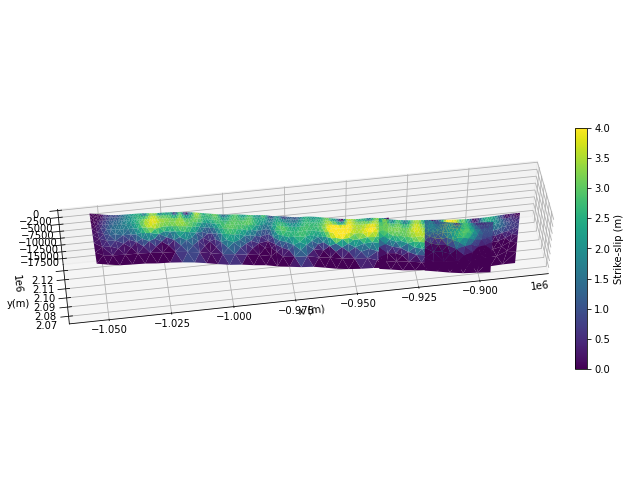

In [31]:
################
### Figures ###
###############
# Plot slip model for the Maduo earthquake 
plot_3d_slip = True 

if plot_3d_slip:
    
    fig = plt.figure(figsize=(10, 7))
    plt.subplots_adjust(top=0.979, bottom=0.021, left=0.015, right=0.985, hspace=0.2, wspace=0.200)

    ax = fig.gca(projection='3d')
    collec = ax.plot_trisurf(xyz1[:,0], xyz1[:,1], xyz1[:,2], triangles=tri1-1, linewidth=0.2,vmin=0, vmax=1)
    collec.set_array(ss1)
    collec.set_clim(0,4)
    collec = ax.plot_trisurf(xyz2[:,0], xyz2[:,1], xyz2[:,2], triangles=tri2-1, linewidth=0.2,vmin=0, vmax=1)
    collec.set_array(ss2)
    collec.set_clim(0,4)
    collec = ax.plot_trisurf(xyz3[:,0], xyz3[:,1], xyz3[:,2], triangles=tri3-1, linewidth=0.2,vmin=0, vmax=1)
    collec.set_array(ss3)
    collec.set_clim(0,4)
    ax.view_init(10,95)
    ax.view_init(47,-98)
    ax.set_box_aspect([6,1,1])  
    #cax = divider.append_axes('right', fraction=0.046, pad=0.04,size=1)
    cbar = fig.colorbar(collec, shrink=0.5)
    cbar.set_label('Strike-slip (m)')
    #cbar = fig.colorbar(collec)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y(m)')
    

### Projection of the subfaults' barycenter

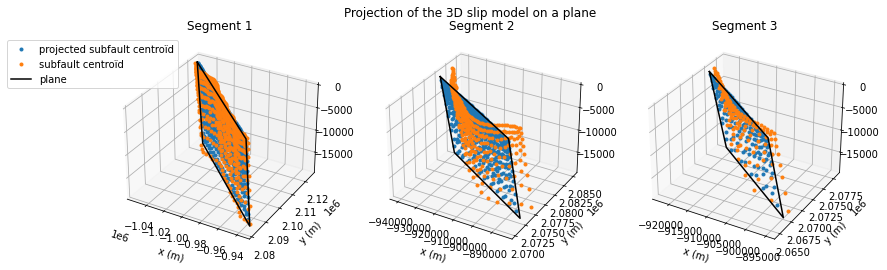

In [32]:
# Plot projection of the barycenter of the subfault on a plane
plot_proj = True

if plot_proj:
    
    fig = plt.figure(figsize=plt.figaspect(0.3))
    fig.suptitle('Projection of the 3D slip model on a plane')
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.plot3D(bary_proj1[:,0], bary_proj1[:,1], bary_proj1[:,2], '.',label='projected subfault centroïd')
    ax.plot3D(xyz1[:,0], xyz1[:,1], xyz1[:,2], '.',label='subfault centroïd')
    ax.plot3D(xp1,yp1,zp1,'k',label='plane')
    #ax.legend()
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title('Segment 1')
    # Put a legend to the left of the current axis
    ax.legend(loc='upper left', bbox_to_anchor=(-0.5, 1))

    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.plot3D(bary_proj2[:,0], bary_proj2[:,1], bary_proj2[:,2], '.',label='projected subfault centroïd')
    ax.plot3D(xyz2[:,0], xyz2[:,1], xyz2[:,2], '.',label='subfault centroïd')
    ax.plot3D(xp2,yp2,zp2,'k',label='plane')
    #ax.legend()
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title('Segment 2')
   
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.plot3D(bary_proj3[:,0], bary_proj3[:,1], bary_proj3[:,2], '.',label='projected subfault centroïd')
    ax.plot3D(xyz3[:,0], xyz3[:,1], xyz3[:,2], '.',label='subfault centroïd')
    ax.plot3D(xp3,yp3,zp3,'k',label='plane')
    #ax.legend()
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title('Segment 3')


### 2D interpolated slip model

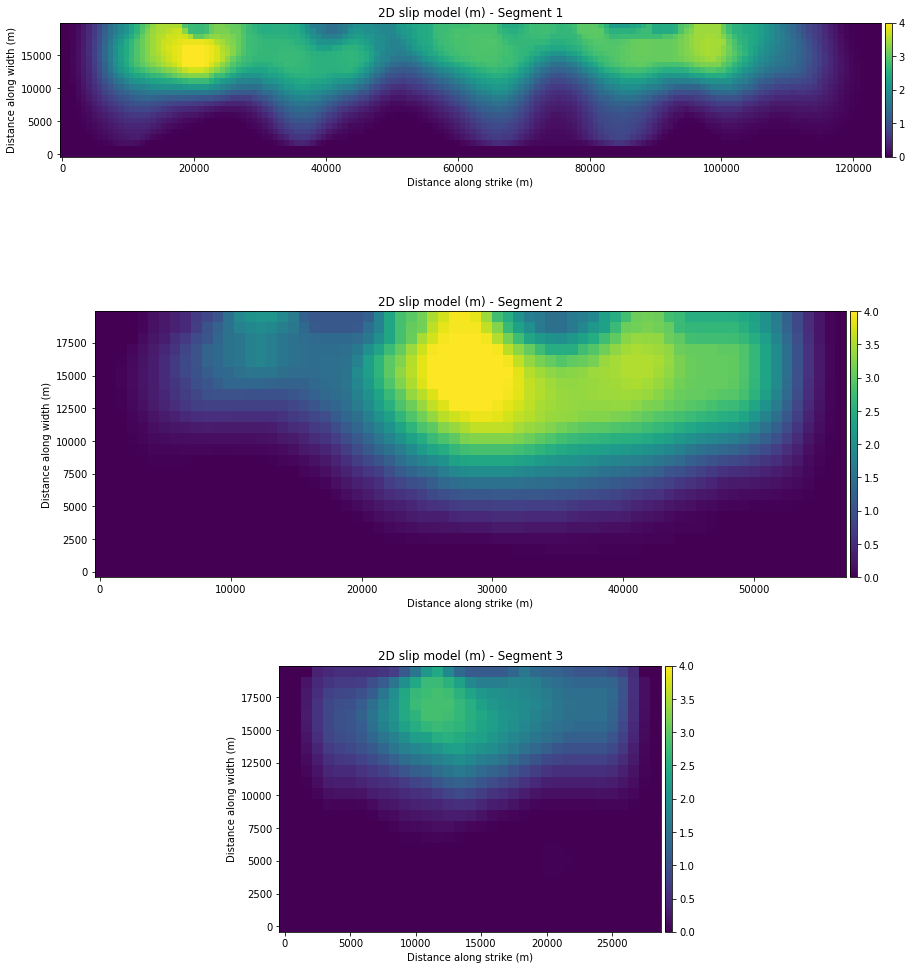

In [33]:
# Plot 2D slip model 
plot_2d_slip = True   

if plot_2d_slip:
    
    fig2, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
    plt.subplots_adjust(top=0.962, bottom=0.059, left=0.029, right=0.992, hspace=0.332, wspace=0.200)
    
    p1 = axs[0].pcolormesh(grid_x1, grid_y1, ssi1tuk2, vmin=0, vmax=4)
    axs[0].set_xlabel('Distance along strike (m)')
    axs[0].set_ylabel('Distance along width (m)')
    axs[0].set_title('2D slip model (m) - Segment 1')
    axs[0].set_aspect('equal', 'box')
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('right', size=0.1, pad=0.05)
    fig2.colorbar(p1, cax=cax, orientation='vertical')
    
    p2 = axs[1].pcolormesh(grid_x2, grid_y2, ssi2tuk2, vmin=0, vmax=4)
    axs[1].set_title('2D slip model (m) - Segment 2')
    axs[1].set_aspect('equal', 'box')
    axs[1].set_xlabel('Distance along strike (m)')
    axs[1].set_ylabel('Distance along width (m)')
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size=0.1, pad=0.05)
    fig2.colorbar(p1, cax=cax, orientation='vertical')
    
    p3 = axs[2].pcolormesh(grid_x3, grid_y3, ssi3tuk2, vmin=0, vmax=4)
    axs[2].set_xlabel('Distance along strike (m)')
    axs[2].set_ylabel('Distance along width (m)')
    axs[2].set_title('2D slip model (m) - Segment 3')
    axs[2].set_aspect('equal', 'box')
    divider = make_axes_locatable(axs[2])
    cax = divider.append_axes('right', size=0.1, pad=0.05)
    fig2.colorbar(p1, cax=cax, orientation='vertical')

